In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy import stats
from scipy.ndimage import gaussian_filter
from dataclasses import dataclass
from typing import Tuple, Dict
from typing import Dict, Tuple, List, Optional

from scipy.spatial.distance import cdist
import odor_stat_calculations as osc
from plume_sim import SimpleOdorPredictor
from scipy.stats import kurtosis
import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import mpl_functions
import sys
sys.path.append("../")
from cfd_rigolli import Cfd_rigolli
from mpl_toolkits.axes_grid1 import make_axes_locatable
import multiprocessing as mp

%load_ext autoreload
%autoreload 2

2024-12-30 13:07:43.296707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-30 13:07:43.307510: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-30 13:07:43.310787: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-30 13:07:43.948315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# if __name__ == "__main__":
#     dirname = '../data/simulator/hws/'
#     df_test = pd.read_hdf(dirname + 'hwsDesert.h5')
#     df_test = df_test
    
#     result = main(df_test['distance_along_streakline'],df_test['nearest_from_streakline'])
    
#     df_test['predicted_odor'] = result['predicted_odor']
#     df_test['whiff_predicted'] = result['whiff_predicted']

In [3]:
class SurgeCastAgent:
    """
    Implementation of surge-cast tracking algorithm that works with external odor input.
    Operates in 2D (x,y) space and integrates with provided odor prediction system.
    """
    def __init__(
            self,
            tau: float = 0.42,      # Timescale of turning (from paper)
            noise: float = 1.9,      # Noise amplitude (from paper)
            bias: float = 0.25,      # Base casting bias (from paper)
            threshold: float = 4.5,   # Odor threshold for detection
            hit_trigger: str = 'peak',
            surge_amp: float = 2.0,   # Surge amplitude
            tau_surge: float = 0.5,   # Surge duration
            cast_freq: float = 1.0,   # Casting frequency (Hz)
            cast_width: float = 0.8,  # Base casting width
            bounds: Optional[List[Tuple[float, float]]] = None  # Environment bounds
        ):
        self.tau = tau
        self.noise = noise
        self.bias = bias
        self.threshold = threshold
        self.hit_trigger = hit_trigger
        self.surge_amp = surge_amp
        self.tau_surge = tau_surge
        self.cast_freq = cast_freq
        self.cast_width = cast_width
        self.bounds = bounds
        
        # Derived parameters
        self.surge_amp_ = surge_amp / (tau_surge * np.exp(-1))

    def reflect_if_out_of_bounds(self, v: np.ndarray, x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Apply boundary conditions if specified"""
        if self.bounds is None:
            return v, x
            
        v_new = v.copy()
        x_new = x.copy()
        
        for dim in range(2):  # Only check x,y dimensions
            if x[dim] < self.bounds[dim][0]:
                v_new[dim] *= -1
                x_new[dim] = 2 * self.bounds[dim][0] - x[dim]
            elif x[dim] > self.bounds[dim][1]:
                v_new[dim] *= -1
                x_new[dim] = 2 * self.bounds[dim][1] - x[dim]
                
        return v_new, x_new
    


In [8]:
def tracking(predictor, bounds, start_pos, target_pos, surge_agent, target_weight, plume_timeout, closest_to_source, duration):
    dt = 0.005       # 200Hz
    n_steps = int(duration / dt)
    # Process all positions first
    print("Processing all positions sequentially...")
    positions_x = np.zeros(n_steps + predictor.config.warmup_steps)
    positions_y = np.zeros(n_steps + predictor.config.warmup_steps)
    
    # Fill warmup steps with start position
    positions_x[:predictor.config.warmup_steps] = start_pos[0]
    positions_y[:predictor.config.warmup_steps] = start_pos[1]
    
    # Initialize tracking arrays
    ts = np.arange(n_steps) * dt
    surges = np.zeros(n_steps)
    bs = np.zeros((n_steps, 2))
    vs = np.zeros((n_steps, 2))
    xs = np.zeros((n_steps, 2))
    hits = np.zeros(n_steps)
    
    # Initial conditions
    x = start_pos.copy()
    v = np.zeros(2)
    last_hit_time = -float('inf')
    
    # Simulate movement first
    print("Simulating movement...")
    for t_ctr in range(n_steps):
        if t_ctr == 0:
            # Initial bias combining upwind and target direction
            to_target = target_pos - x
            to_target = to_target / (np.linalg.norm(to_target) + 1e-6)
            upwind = np.array([-1.0, 0.0])
            b = (1 - target_weight) * upwind + target_weight * to_target
            b = b * (surge_agent.bias / np.linalg.norm(b))
        else:
            eta = np.random.normal(0, surge_agent.noise, (2,))
            time_since_hit = t_ctr * dt - last_hit_time
            
            # Calculate target direction
            to_target = target_pos - x
            dist_to_target = np.linalg.norm(to_target)
            
            # Check if we've reached the target
            if dist_to_target < closest_to_source:
                print(f"Target reached at position ({x[0]:.2f}, {x[1]:.2f})")
                xs[t_ctr:] = x
                bs[t_ctr:] = b
                vs[t_ctr:] = np.zeros(2)
                break
                
            to_target = to_target / (dist_to_target + 1e-6)
            
            # Adjust target weight based on time since last hit
            current_target_weight = target_weight
            if time_since_hit > plume_timeout:
                current_target_weight = min(0.8, target_weight + 
                    0.1 * (time_since_hit - plume_timeout) / plume_timeout)
            
            if surges[t_ctr] > 1.0:
                # During surge: combine upwind motion with target seeking
                surge_direction = np.array([-1.0, -0.05 * x[1]])
                surge_direction = surge_direction / np.linalg.norm(surge_direction)
                b = (1 - current_target_weight) * surge_direction + current_target_weight * to_target
                b = b * surges[t_ctr]
            else:
                # During cast: crosswind motion plus target bias
                cast_freq = 0.5  # Hz
                cast_phase = np.sin(2 * np.pi * t_ctr * dt * cast_freq)
                
                # Adaptive casting width based on distance
                base_cast_width = 1.0
                dist_factor = min(1.0, dist_to_target / 20.0)
                cast_width = base_cast_width * dist_factor
                
                # Combine behaviors
                crosswind = np.array([0.0, cast_phase * cast_width])
                upwind = np.array([-0.2, 0.0])
                b = (1 - current_target_weight) * (upwind + crosswind) + current_target_weight * to_target
                b = b * (surge_agent.bias / np.linalg.norm(b))
            
            v += (dt / surge_agent.tau) * (-v + eta + b)
            x += v * dt
        
        # Apply boundaries
        v, x = surge_agent.reflect_if_out_of_bounds(v, x)
        
        # Store state
        bs[t_ctr] = b
        vs[t_ctr] = v
        xs[t_ctr] = x
        
        # Store position for odor prediction
        positions_x[predictor.config.warmup_steps + t_ctr] = x[0]
        positions_y[predictor.config.warmup_steps + t_ctr] = x[1]

    if t_ctr < n_steps - 1:
        valid_steps = t_ctr + 1
        xs = xs[:valid_steps]
        bs = bs[:valid_steps]
        vs = vs[:valid_steps]
        ts = ts[:valid_steps]
        positions_x = positions_x[:predictor.config.warmup_steps + valid_steps]
        positions_y = positions_y[:predictor.config.warmup_steps + valid_steps]
    
    # Now get odor predictions for entire trajectory
    print("Getting odor predictions...")
    result = predictor.predict_odor_concentration(positions_x, positions_y)
    odors = result['predicted_odor'].values[predictor.config.warmup_steps:]
    whiffs = result['whiff_predicted'].values[predictor.config.warmup_steps:]
    
    # Process hits based on odor
    print("Processing hits...")
    last_odor = 0
    hit_occurred = False
    
    surges = np.zeros_like(odors)  # Initialize surges array to match odors length
    hits = np.zeros_like(odors)
    
    for t_ctr in range(len(odors)):
        odor = odors[t_ctr]
        
        if surge_agent.hit_trigger == 'peak':
            if odor >= surge_agent.threshold:
                if odor <= last_odor and not hit_occurred:
                    hits[t_ctr] = 1
                    hit_occurred = True
                    last_hit_time = t_ctr * dt  # Update last hit time for adaptive behavior
                last_odor = odor
        
        if odor < surge_agent.threshold:
            last_odor = 0
            hit_occurred = False
            
        # Add surge force if hit detected
        if hits[t_ctr]:
            ts_valid = ts[:len(odors)]
            ts_ = ts_valid[t_ctr:] - ts_valid[t_ctr]
            # Reset previous surge forces
            surges[t_ctr:] = 0  
            # Add new surge with maximum cap
            surge_force = surge_agent.surge_amp_ * ts_ * np.exp(-ts_/surge_agent.tau_surge)
            surges[t_ctr:] = np.minimum(surge_force, 50.0)
    
    # Plotting
    fig, axs = plt.subplots(3, 1, figsize=(8, 8))

    # Trajectory
    axs[0].plot(xs[:, 0], xs[:, 1], 'b-', alpha=0.6, label='Path')
    axs[0].plot(start_pos[0], start_pos[1], 'go', label='Start')
    axs[0].plot(target_pos[0], target_pos[1], 'ro', label='Target')
    axs[0].plot(xs[-1, 0], xs[-1, 1], 'mo', label='End')
    hit_points = hits == 1
    if np.any(hit_points):
        axs[0].plot(xs[hit_points, 0], xs[hit_points, 1], 'g*', markersize=5, label='Whiffs')
    axs[0].set_xlabel('X Position (m)')
    axs[0].set_ylabel('Y Position (m)')
    # axs[0].set_ylim(0, 8)
    axs[0].set_title(f'Tracking Trajectory (Whiffs: {np.sum(hits)})')
    axs[0].legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0.)

    # Odor concentration and whiffs
    axs[1].plot(ts[:len(odors)], odors, 'b-', label='Odor')
    # axs[1].plot(ts[:len(whiffs)], whiffs * surge_agent.threshold, 'g.', label='Predictor Whiffs')
    if np.any(hit_points):
        axs[1].plot(ts[:len(odors)][hit_points], odors[hit_points], 'r*', label='Detected Whiffs')
    axs[1].axhline(y=surge_agent.threshold, color='r', linestyle='--', label=f'Threshold={surge_agent.threshold}')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Odor Concentration')
    axs[1].set_title('Odor Concentration vs Time')
    axs[1].legend(bbox_to_anchor=(1.3, 1), loc='upper right', borderaxespad=0.)

    # Forces
    axs[2].plot(ts[:len(bs)], np.linalg.norm(bs, axis=1), 'g-', label='Bias Force')
    axs[2].plot(ts[:len(surges)], surges, 'r-', label='Surge Force')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Force Magnitude')
    axs[2].set_title('Control Forces')
    axs[2].legend(bbox_to_anchor=(1.25, 1), loc='upper right', borderaxespad=0.)

    fig.tight_layout()
    print("\nTracking Statistics:")
    print(f"Duration: {len(ts[:len(odors)]) * dt:.1f} seconds")
    print(f"Total steps: {len(odors)}")
    print(f"Whiffs detected: {np.sum(hits)}")
    print(f"Predictor whiffs: {np.sum(whiffs)}")
    print(f"Odor range: {np.min(odors):.2f} to {np.max(odors):.2f}")
    print(f"Mean odor: {np.mean(odors):.2f}")
    print(f"Time above threshold: {np.mean(odors > surge_agent.threshold)*100:.1f}%")
    
    if t_ctr < n_steps - 1:
        print(f"Target reached at ({x[0]:.2f}, {x[1]:.2f})")
        
    return odors,xs,ts

Processing all positions sequentially...
Simulating movement...
Target reached at position (0.04, -0.09)
Getting odor predictions...
Processing hits...

Tracking Statistics:
Duration: 233.7 seconds
Total steps: 46739
Whiffs detected: 251.0
Predictor whiffs: 2801
Odor range: 0.70 to 10.20
Mean odor: 1.41
Time above threshold: 5.8%
Target reached at (0.04, -0.09)


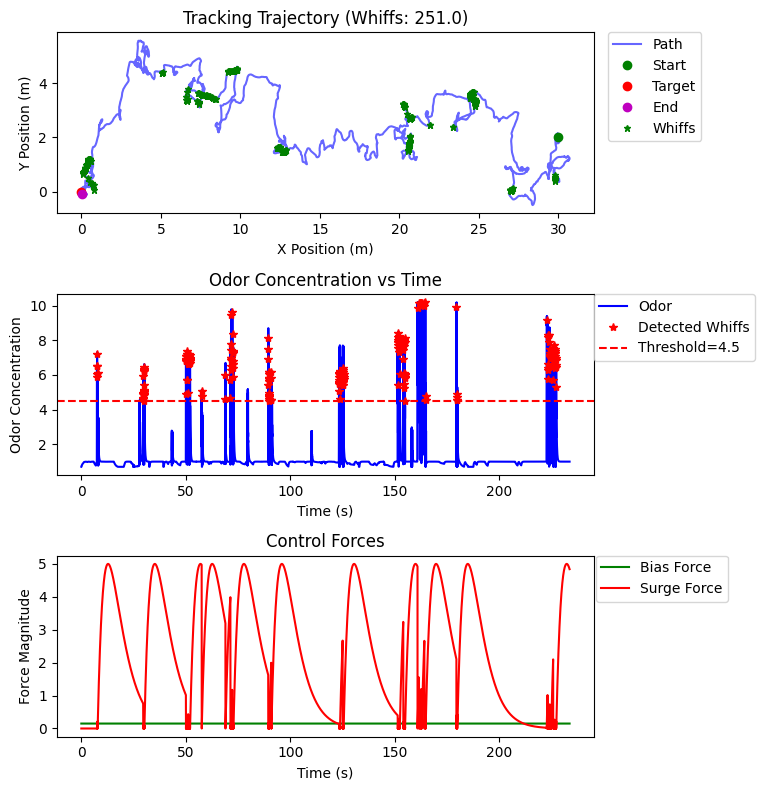

In [9]:
if __name__ == "__main__":
        # Initialize odor predictor
    dirname = '../data/simulator/hws/'
    hmap_data = np.load(str(dirname) + "hmap.npz")
    fdf = pd.read_hdf(str(dirname) + 'whiff.h5')
    fdf_nowhiff = pd.read_hdf(str(dirname) + 'nowhiff.h5')
    
    predictor = SimpleOdorPredictor(
        fitted_p_heatmap=hmap_data['fitted_heatmap'],
        xedges=hmap_data['xedges'],
        yedges=hmap_data['yedges'],
        fdf=fdf,
        fdf_nowhiff=fdf_nowhiff
    )
    
    # Set up tracking parameters
    bounds = [(0, 50), (-20, 20)]
    start_pos = np.array([30.0, 2.0])
    target_pos = np.array([0.0, 0.0])  # Target position (can be modified)
    
    # Create surge-cast agent
    surge_agent = SurgeCastAgent(
        tau=0.42,           # Timescale of turning
        noise=5,            # Noise for casting
        bias=0.15,          # Reduced casting bias
        threshold=4.5,      # Threshold for whiff detection
        hit_trigger='peak',
        surge_amp=5.0,      # Surge amplitude
        tau_surge=5,        # Surge duration
        bounds=bounds
    )
    
    # Additional tracking parameters
    target_weight = 0.3     # Weight for target-seeking behavior (0-1)
    plume_timeout = 10.0    # Seconds before increasing target bias
    closest_to_source =0.1
    # Simulation parameters
    sim_duration = 250.0  # seconds

    
    result, trajectories, time = tracking(predictor, bounds, start_pos, target_pos, surge_agent, target_weight, plume_timeout, closest_to_source, sim_duration)

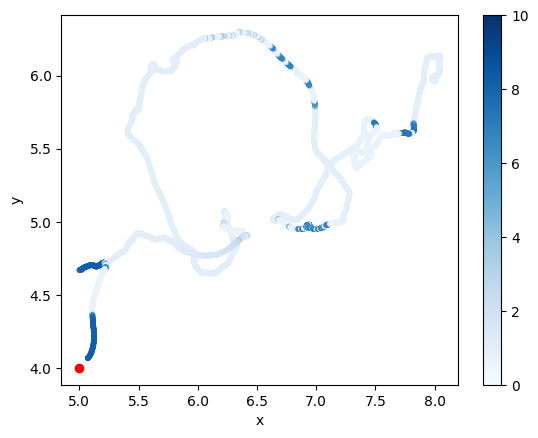

In [59]:
# plt.scatter(trajectories[:, 0],trajectories[:, 1], c=result, cmap='Blues', s=10, vmin=0, vmax=10)
# plt.colorbar()
# plt.xlabel('x')
# plt.ylabel('y')
# plt.plot(5,4,'o', c='red')

In [5]:
# f,(ax1,ax2)= plt.subplots(2,1,figsize=(6,4))
# ax1.plot(df_test.time, df_test.odor, label='original')
# ax2.plot(df_test.time, df_test.predicted_odor, label='predicted')
# ax1.axhline(4.5, color = 'r', linestyle = '--')
# ax2.axhline(4.5, color = 'r', linestyle = '--')
# limit = (1288,1350)
# ax1.set_xlim(limit)
# ax2.set_xlim(limit)
# ax2.set_ylabel('odor, a.u.')
# ax2.set_xlabel('time,s')
# ax1.set_title('Original Odor ')
# ax2.set_title('Predicted Odor')
# f.tight_layout()

Rigolli Tracker

In [12]:
class CfdOdorPredictor:
    def __init__(self, cfd_simulator, scale_data_fn):
        self.cfd = cfd_simulator
        self.scale_data = scale_data_fn
        self.config = type('Config', (), {
            'warmup_steps': 0,
            'rows_per_second': 200
        })()

    def get_wind_at_position(self, pos: Tuple[float, float], time: float) -> Tuple[float, float, float]:
        return self.cfd.get_wind_at_position_and_time(pos, time)

    def get_odor_at_position(self, pos: Tuple[float, float], time: float) -> float:
        odor = self.cfd.get_odor_at_position_and_time(pos, time)
        return odor

def modified_tracking(cfd_predictor, bounds, start_pos, target_pos, surge_agent, 
                     target_weight, plume_timeout, closest_to_source, duration):
    dt = 0.005
    n_steps = int(duration / dt)
    
    ts = np.arange(n_steps) * dt
    surges = np.zeros(n_steps)
    bs = np.zeros((n_steps, 2))
    vs = np.zeros((n_steps, 2))
    xs = np.zeros((n_steps, 2))
    hits = np.zeros(n_steps)
    raw_odors = np.zeros(n_steps)
    
    x = start_pos.copy()
    v = np.zeros(2)
    last_hit_time = -float('inf')
    
    for t_ctr in range(n_steps):
        current_time = t_ctr * dt
        raw_odors[t_ctr] = cfd_predictor.get_odor_at_position(tuple(x), current_time)
        
        wind_vel = cfd_predictor.get_wind_at_position(tuple(x), current_time)
        wind_direction = np.array([wind_vel[0], wind_vel[1]])
        wind_direction = wind_direction / (np.linalg.norm(wind_direction) + 1e-6)
        
        if t_ctr == 0:
            to_target = target_pos - x
            to_target = to_target / (np.linalg.norm(to_target) + 1e-6)
            b = (1 - target_weight) * wind_direction + target_weight * to_target
            b = b * (surge_agent.bias / np.linalg.norm(b))
        else:
            eta = np.random.normal(0, surge_agent.noise, (2,))
            time_since_hit = current_time - last_hit_time
            
            to_target = target_pos - x
            dist_to_target = np.linalg.norm(to_target)
            
            if dist_to_target < closest_to_source:
                print(f"Target reached at ({x[0]:.2f}, {x[1]:.2f})")
                xs[t_ctr:] = x
                bs[t_ctr:] = b
                vs[t_ctr:] = np.zeros(2)
                break
                
            to_target = to_target / (dist_to_target + 1e-6)
            
            current_target_weight = target_weight
            if time_since_hit > plume_timeout:
                current_target_weight = min(0.8, target_weight + 
                    0.1 * (time_since_hit - plume_timeout) / plume_timeout)
            
            if surges[t_ctr] > 1.0:
                b = (1 - current_target_weight) * wind_direction + current_target_weight * to_target
                b = b * surges[t_ctr]
            else:
                crosswind_direction = np.array([-wind_direction[1], wind_direction[0]])
                cast_phase = np.sin(2 * np.pi * current_time * surge_agent.cast_freq)
                
                base_cast_width = surge_agent.cast_width
                dist_factor = min(1.0, dist_to_target / 20.0)
                cast_width = base_cast_width * dist_factor
                
                cast_motion = crosswind_direction * cast_phase * cast_width
                b = (1 - current_target_weight) * (0.2 * wind_direction + cast_motion) + current_target_weight * to_target
                b = b * (surge_agent.bias / np.linalg.norm(b))
            
            v += (dt / surge_agent.tau) * (-v + eta + b)
            x += v * dt
        
        v, x = surge_agent.reflect_if_out_of_bounds(v, x)
        bs[t_ctr] = b
        vs[t_ctr] = v
        xs[t_ctr] = x

    # Scale odors after collecting all values
    odors = cfd_predictor.scale_data(raw_odors)
    
    # Process hits
    last_odor = 0
    hit_occurred = False
    
    for t_ctr in range(len(odors)):
        odor = odors[t_ctr]
        
        if surge_agent.hit_trigger == 'peak':
            if odor >= surge_agent.threshold:
                if odor <= last_odor and not hit_occurred:
                    hits[t_ctr] = 1
                    hit_occurred = True
                    last_hit_time = t_ctr * dt
                last_odor = odor
        
        if odor < surge_agent.threshold:
            last_odor = 0
            hit_occurred = False
            
        if hits[t_ctr]:
            ts_ = ts[t_ctr:] - ts[t_ctr]
            surges[t_ctr:] = 0
            surge_force = surge_agent.surge_amp_ * ts_ * np.exp(-ts_/surge_agent.tau_surge)
            surges[t_ctr:] = np.minimum(surge_force, 50.0)
    
    # Visualization
    fig, axs = plt.subplots(3, 1, figsize=(8, 8))

    axs[0].plot(xs[:, 0], xs[:, 1], 'b-', alpha=0.6, label='Path')
    axs[0].plot(start_pos[0], start_pos[1], 'go', label='Start')
    axs[0].plot(target_pos[0], target_pos[1], 'ro', label='Target')
    axs[0].plot(xs[-1, 0], xs[-1, 1], 'mo', label='End')
    hit_points = hits == 1
    if np.any(hit_points):
        axs[0].plot(xs[hit_points, 0], xs[hit_points, 1], 'g*', markersize=5, label='Whiffs')
    axs[0].set_xlabel('X Position (m)')
    axs[0].set_ylabel('Y Position (m)')
    axs[0].set_ylim(0, 8)
    axs[0].set_title(f'Tracking Trajectory (Whiffs: {np.sum(hits)})')
    axs[0].legend(bbox_to_anchor=(1.2, 1), loc='upper right')

    axs[1].plot(ts, odors, 'b-', label='Scaled Odor')
    axs[1].plot(ts, raw_odors, 'g-', alpha=0.5, label='Raw Odor')
    if np.any(hit_points):
        axs[1].plot(ts[hit_points], odors[hit_points], 'r*', label='Detected Whiffs')
    axs[1].axhline(y=surge_agent.threshold, color='r', linestyle='--', label=f'Threshold={surge_agent.threshold}')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Odor Concentration')
    axs[1].set_title('Odor Concentration vs Time')
    axs[1].legend(bbox_to_anchor=(1.3, 1), loc='upper right')

    axs[2].plot(ts[:len(bs)], np.linalg.norm(bs, axis=1), 'g-', label='Bias Force')
    axs[2].plot(ts[:len(surges)], surges, 'r-', label='Surge Force')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Force Magnitude')
    axs[2].set_title('Control Forces')
    axs[2].legend(bbox_to_anchor=(1.25, 1), loc='upper right')

    fig.tight_layout()
    
    print("\nTracking Statistics:")
    print(f"Duration: {len(ts) * dt:.1f} seconds")
    print(f"Total steps: {len(odors)}")
    print(f"Whiffs detected: {np.sum(hits)}")
    print(f"Raw odor range: {np.min(raw_odors):.2f} to {np.max(raw_odors):.2f}")
    print(f"Scaled odor range: {np.min(odors):.2f} to {np.max(odors):.2f}")
    print(f"Mean odor: {np.mean(odors):.2f}")
    print(f"Time above threshold: {np.mean(odors > surge_agent.threshold)*100:.1f}%")
        
    return odors, xs, ts

Target reached at (5.01, 3.90)

Tracking Statistics:
Duration: 50.0 seconds
Total steps: 10000
Whiffs detected: 84.0
Raw odor range: 0.00 to 17.12
Scaled odor range: 0.00 to 10.00
Mean odor: 2.32
Time above threshold: 18.1%


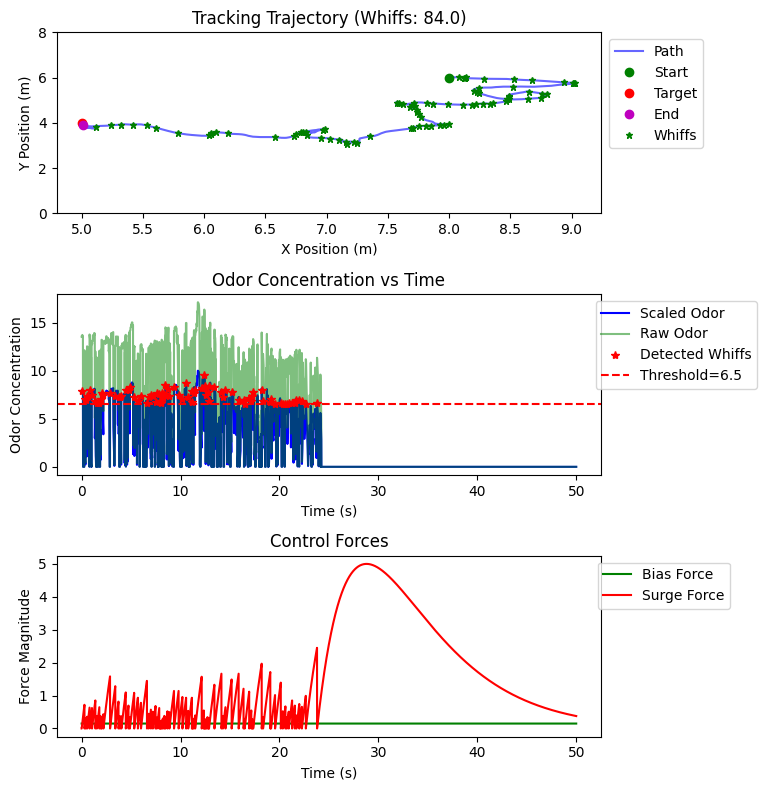

In [14]:
def scale_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (((data - min_val) / (max_val - min_val)) * 10)


cfd = Cfd_rigolli(dirname="../data/rigolli/")
cfd_predictor = CfdOdorPredictor(cfd, scale_data)

bounds = [(5, 40), (0, 8)]
start_pos = np.array([8.0, 6.0])
target_pos = np.array([5.0, 4.0])

# Create surge-cast agent (same as before)
surge_agent = SurgeCastAgent(
    tau=0.42,
    noise=5,
    bias=0.15,
    threshold=6.5,
    hit_trigger='peak',
    surge_amp=5.0,
    tau_surge=5,
    bounds=bounds
)

# Run tracking with new simulator
target_weight = 0.3
plume_timeout = 10.0
closest_to_source = 0.1
sim_duration = 50.0

result, trajectories, times = modified_tracking(
    cfd_predictor, 
    bounds, 
    start_pos, 
    target_pos, 
    surge_agent, 
    target_weight, 
    plume_timeout, 
    closest_to_source, 
    sim_duration
)

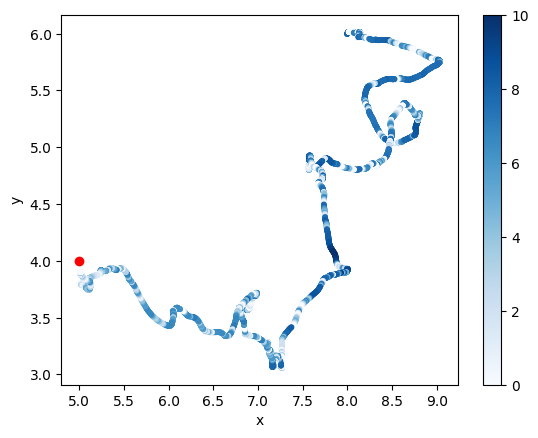

In [30]:
plt.scatter(trajectories[:, 0],trajectories[:, 1], c=result, cmap='Blues', s=10, vmin=0, vmax=10)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.plot(5,4,'o', c='red')

In [18]:
th=4.5
query1 = 'odor>'+str(th)
new_test_df1=pd.DataFrame()
new_test_df1 = df_test.query(query1)
new_test_df1.reset_index(inplace=True, drop=True)

query2 = 'predicted_odor>'+str(th)
new_test_df2=pd.DataFrame()
new_test_df2 = df_test.query(query2)
new_test_df2.reset_index(inplace=True, drop=True)

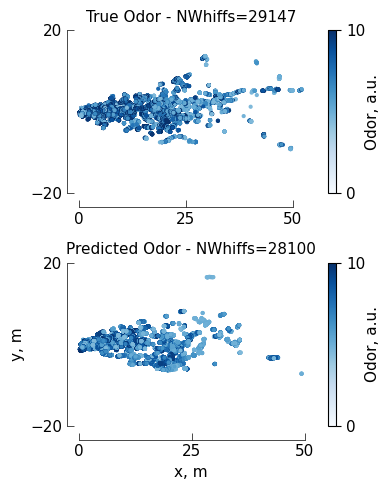

In [19]:
f, ax = plt.subplots(2, 1, figsize=(4, 5))

cax1 = ax[0].scatter(new_test_df1.distance_along_streakline, new_test_df1.nearest_from_streakline, c=new_test_df1.odor, s = 4, cmap='Blues', vmin=0, vmax=10)
cax2 = ax[1].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.predicted_odor, s = 4, cmap='Blues', vmin=0, vmax=10)
# cax3 = ax[2].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.whiff_predicted, s = 4, cmap='Blues', vmin=0, vmax=1)
# ylim=(-15,25)

ax[0].set_title('True Odor - NWhiffs='+str(len(new_test_df1)))
ax[1].set_title('Predicted Odor - NWhiffs='+str(len(new_test_df2)))
ax[1].set_xlabel('x, m')
ax[1].set_ylabel('y, m')

cb1=plt.colorbar(cax1)
cb2=plt.colorbar(cax2)

cb1.set_label('Odor, a.u.',labelpad=0)
cb2.set_label('Odor, a.u.',labelpad=0)


cb1.set_ticks([0,10])
cb2.set_ticks([0,10])
# cb3.set_ticks([0, 1])
for i in range(2):
    # mpl_functions.adjust_spines(ax[i],['left','bottom'],
    #                         spine_locations={'left': 1}, 
    #                         smart_bounds=True,
    #                         xticks=[0,25,50],
    #                         yticks=[0,8],
    #                         linewidth=0.5)
    # mpl_functions.set_fontsize(ax[i],11)
    mpl_functions.adjust_spines(ax[i],['left','bottom'],
                        spine_locations={'left': 1}, 
                        smart_bounds=True,
                        xticks=[0,25,50],
                        yticks=[-20,20],
                        linewidth=0.5)
    mpl_functions.set_fontsize(ax[i],11)

f.tight_layout()

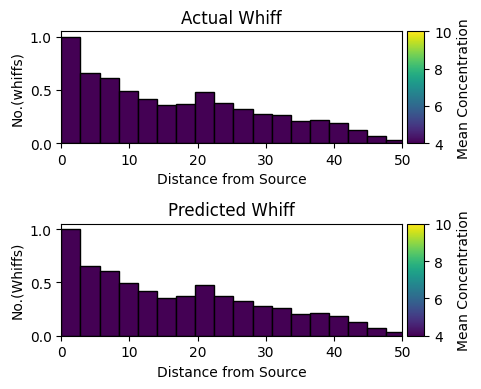

In [17]:
# Number of bins and plot limits
n_bins = 20
# Actual Whiff Data
df_actual = new_test_df1.copy()
bins = np.linspace(0, df_actual['distance_from_source'].max(), n_bins + 1)
df_actual['distance_bin'] = pd.cut(df_actual['distance_from_source'], bins=bins)

whiff_counts_actual = df_actual.groupby('distance_bin').size()
mean_concentrations_actual = df_actual.groupby('distance_bin')['odor'].mean()
bin_centers_actual = (bins[:-1] + bins[1:]) / 2

# Normalize actual whiff counts
whiff_counts_actual_normalized = whiff_counts_actual / whiff_counts_actual.max()

# Predicted Whiff Data
df_predicted = new_test_df2.copy()
bins_predicted = np.linspace(0, df_predicted['distance_from_source'].max(), n_bins + 1)
df_predicted['distance_bin'] = pd.cut(df_predicted['distance_from_source'], bins=bins_predicted)

whiff_counts_predicted = df_predicted.groupby('distance_bin').size()
mean_concentrations_predicted = df_predicted.groupby('distance_bin')['predicted_odor'].mean()
bin_centers_predicted = (bins_predicted[:-1] + bins_predicted[1:]) / 2

# Normalize predicted whiff counts
whiff_counts_predicted_normalized = whiff_counts_predicted / whiff_counts_predicted.max()

# Create the subplots
f, ax = plt.subplots(2, 1, figsize=(5, 4))

# Plot for Actual Whiff Data
norm_actual = plt.Normalize(4, 10)
colors_actual = plt.cm.viridis(norm_actual(mean_concentrations_actual))
bars_actual = ax[0].bar(bin_centers_actual, whiff_counts_actual_normalized, width=(bins[1] - bins[0]), edgecolor='black', color=colors_actual)

divider_actual = make_axes_locatable(ax[0])
cax_actual = divider_actual.append_axes("right", size="5%", pad=0.05)
sm_actual = plt.cm.ScalarMappable(cmap='viridis', norm=norm_actual)
sm_actual.set_array([])
cbar_actual = plt.colorbar(sm_actual, cax=cax_actual)
cbar_actual.set_label('Mean Concentration')

ax[0].set_xlabel('Distance from Source')
ax[0].set_ylabel('No.(whiffs)')
ax[0].set_title('Actual Whiff')
# ax[0].set_ylim(ylim)
ax[0].set_xlim(0, 50)

# Plot for Predicted Whiff Data
norm_predicted = plt.Normalize(4, 10)
colors_predicted = plt.cm.viridis(norm_predicted(mean_concentrations_predicted))
bars_predicted = ax[1].bar(bin_centers_predicted, whiff_counts_predicted_normalized, width=(bins_predicted[1] - bins_predicted[0]), edgecolor='black', color=colors_predicted)

divider_predicted = make_axes_locatable(ax[1])
cax_predicted = divider_predicted.append_axes("right", size="5%", pad=0.05)
sm_predicted = plt.cm.ScalarMappable(cmap='viridis', norm=norm_predicted)
sm_predicted.set_array([])
cbar_predicted = plt.colorbar(sm_predicted, cax=cax_predicted)
cbar_predicted.set_label('Mean Concentration')

ax[1].set_xlabel('Distance from Source')
ax[1].set_ylabel('No.(Whiffs)')
ax[1].set_title('Predicted Whiff')
ylim = (0, 1)
# ax[1].set_ylim(ylim)
ax[1].set_xlim(0, 50)

# Adjust the layout
f.tight_layout()



In [8]:
new_test_df1=df_test.copy()
new_test_df2=df_test.copy()

def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)
th = 4.5
np.seterr(divide='ignore')
index = osc.get_index(new_test_df1.odor,th)
index_predicted = osc.get_index(new_test_df2.predicted_odor,th)
fdf1 = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(new_test_df1,index,fdf1)
cal_stat_predicted(new_test_df2,index_predicted, fdf_predicted)

fdf1.keys()

/home/gorilla/An/plume_sim/odor_stat_calculations.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.efreq.iloc[start] = 1


Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time'],
      dtype='object')

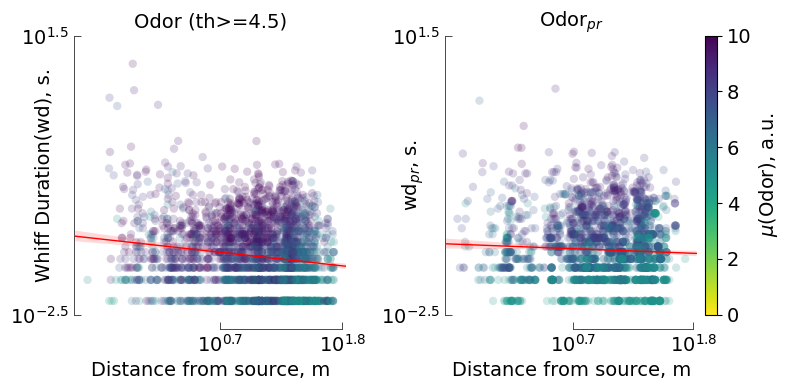

In [9]:
### WHIFF DURATION
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf1.log_avg_dist_from_source,fdf1.log_whiff, c=fdf1.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2,vmin=0,vmax=10)
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source,y=fdf1.log_whiff , data=fdf1,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
# cbar.solids.set(alpha=1)
# cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source, m')
ax1.set_ylabel('Whiff Duration(wd), s.')
ax1.set_title('Odor (th>='+str(th)+')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

u=ax2.scatter(fdf_predicted.log_avg_dist_from_source,
              fdf_predicted.log_whiff, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2, vmin=0,vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source,y=fdf_predicted.log_whiff , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(Odor), a.u.')

ax2.set_xlabel('Distance from source, m')
ax2.set_title('Odor$_{pr}$')
ax2.set_ylabel('wd$_{pr}$, s.')
ax2.yaxis.set_label_coords(-0.08, 0.5)
mpl_functions.adjust_spines(ax1,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0.7,1.8],
                            yticks=[-2.5,1.5],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0.7,1.8],
                            yticks=[-2.5,1.5],
                            linewidth=0.5)
ax1.set_yticklabels([r'$10^{-2.5}$',r'$10^{1.5}$'])
ax1.set_xticklabels([r'$10^{0.7}$',r'$10^{1.8}$'])
ax2.set_yticklabels([r'$10^{-2.5}$',r'$10^{1.5}$'])
ax2.set_xticklabels([r'$10^{0.7}$',r'$10^{1.8}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout()


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8944.41it/s]


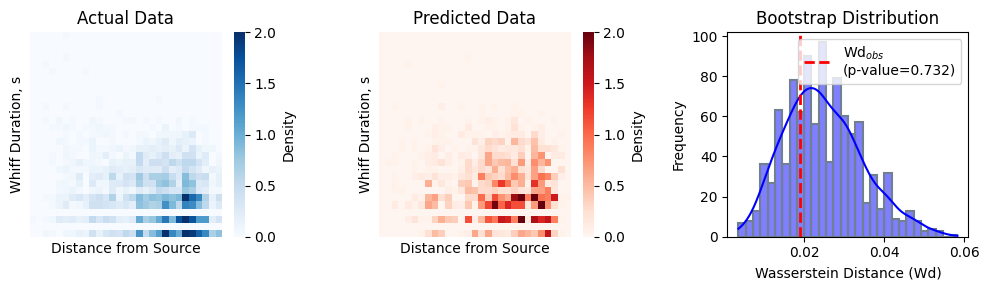

In [10]:
## Duration:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.log_whiff, fdf_predicted.log_avg_dist_from_source, fdf_predicted.log_whiff, 'Whiff Duration, s', 0,2)

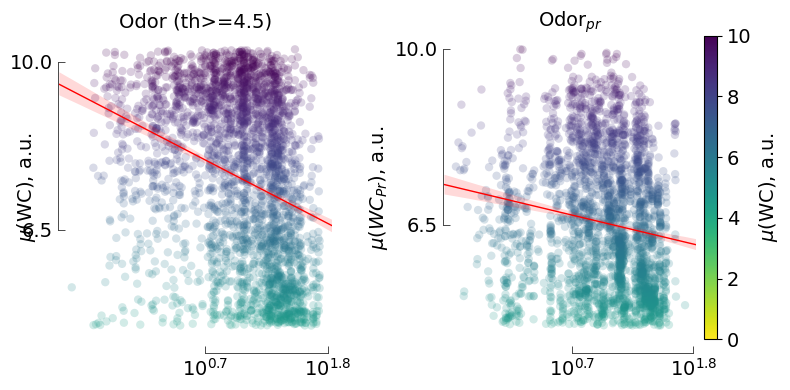

In [11]:
### Whiff concentration
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual odor
var1 = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.mean_concentration, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                   alpha=0.2, vmin=0, vmax=10)


g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.mean_concentration, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar = f.colorbar(var1, cax=cax, orientation='vertical')
# cbar.solids.set(alpha=1)
# cbar.set_label('$\mu$(WC), a.u.')

# ax1.set_xlabel('Distance from source (log), m')
ax1.set_title('Odor (th>=' + str(th) + ')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

# Plot for predicted odor
var2 = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.mean_concentration, c=fdf_predicted.mean_concentration,
                   cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.mean_concentration, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(var2, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# ax2.set_xlabel('Distance from source (log), m')
ax2.set_title('Odor$_{pr}$')
ax1.set_ylabel('$\mu$(WC), a.u.')
ax2.set_ylabel('$\mu(WC_{Pr})$, a.u.')
# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0.7, 1.8],
                            yticks=[6.5, 10],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0.7, 1.8],
                            yticks=[6.5, 10],
                            linewidth=0.5)

# Set custom tick labels
# ax1.set_yticklabels([r'$4$', r'$10$'])
ax1.set_xticklabels([r'$10^{0.7}$', r'$10^{1.8}$'])
# ax2.set_yticklabels([r'$4$', r'$10$'])
ax2.set_xticklabels([r'$10^{0.7}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 9066.45it/s]


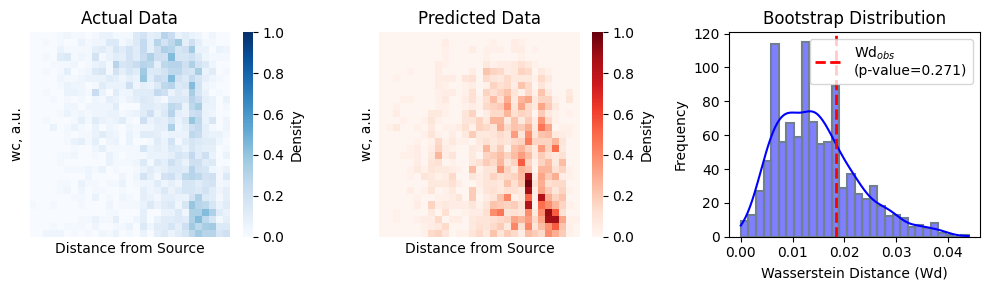

In [12]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.mean_concentration, fdf_predicted.log_avg_dist_from_source, fdf_predicted.mean_concentration, 'wc, a.u.',0,1)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8414.12it/s]


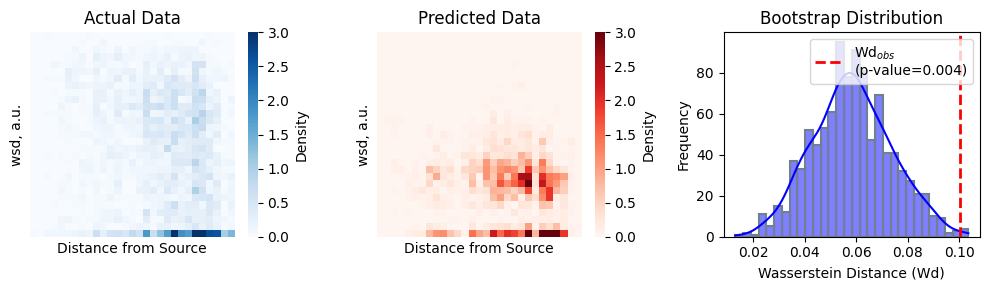

In [13]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.std_whiff, fdf_predicted.log_avg_dist_from_source, fdf_predicted.std_whiff, 'wsd, a.u.', 0,3)

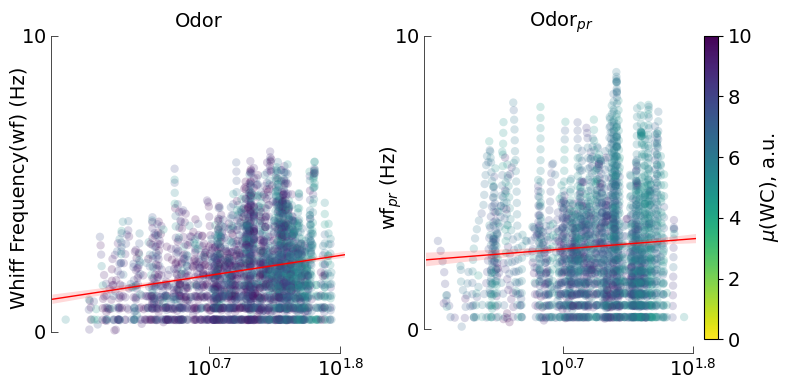

In [14]:
### WHIFF FREQUENCY
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual odor
var = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.wf, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=10)
ax1.set_ylabel('Whiff Frequency (Hz)')

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.wf, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)
ax1.set_title('Odor')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.wf, c=fdf_predicted.mean_concentration,
                cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.wf, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set the titles and labels
ax2.set_title('Odor$_{pr}$')
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
ax1.set_ylabel('Whiff Frequency(wf) (Hz)')
ax2.set_ylabel('wf$_{pr}$ (Hz)')

# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0.7, 1.8],
                            yticks=[0,12],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0.7, 1.8],
                            yticks=[0, 12],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$0$', r'$10$'])
ax1.set_xticklabels([r'$10^{0.7}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$0$', r'$10$'])
ax2.set_xticklabels([r'$10^{0.7}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 10149.61it/s]


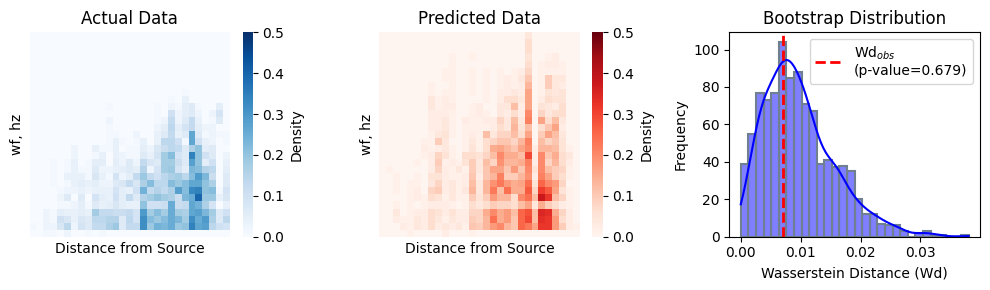

In [15]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.wf, fdf_predicted.log_avg_dist_from_source, fdf_predicted.wf, 'wf, hz',0,0.5)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 9865.56it/s]


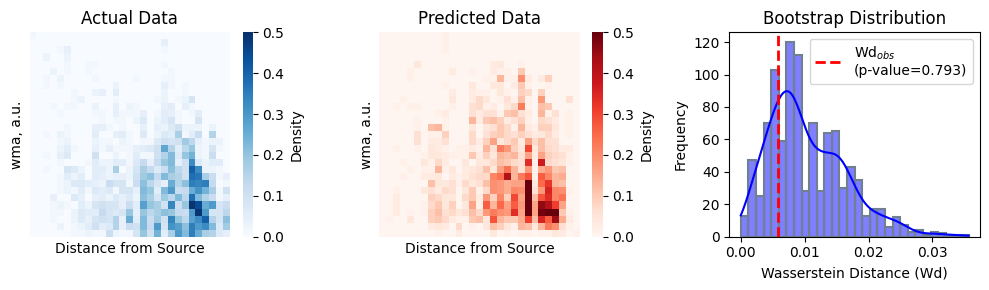

In [16]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.whiff_ma, fdf_predicted.log_avg_dist_from_source, fdf_predicted.whiff_ma, 'wma, a.u.', 0,0.5)